In [14]:
import numpy as np
import pandas as pd
import datetime
import time
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import gc
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import seaborn as sns

In [15]:
taxi = pd.read_table("C:/Users/Petro Ck/OneDrive/Task 2/_petro/no_fucking_index.csv", sep = ",")

In [18]:
taxi["tpep_pickup_datetime"] = pd.to_datetime(taxi["tpep_pickup_datetime"])
taxi["tpep_dropoff_datetime"] = pd.to_datetime(taxi["tpep_dropoff_datetime"])

In [19]:
pickup = pd.to_datetime(taxi["tpep_pickup_datetime"])
dropoff = pd.to_datetime(taxi["tpep_dropoff_datetime"])

In [20]:
workdays = taxi["tpep_pickup_datetime"][(pickup.dt.dayofweek != 5) & (pickup.dt.dayofweek != 6)]

In [21]:
weekends = taxi["tpep_pickup_datetime"][(pickup.dt.dayofweek == 5) | (pickup.dt.dayofweek == 6)]

In [22]:
gc.collect()

129

#### Load test set and attributes

In [107]:
taxi_test = pd.read_table("C:/Users/Petro Ck/OneDrive/Task 2/data/taxi_test_4.csv", sep = ",")
taxi_test["tpep_pickup_datetime"] = pd.to_datetime(taxi_test["tpep_pickup_datetime"])
taxi_test["tpep_dropoff_datetime"] = pd.to_datetime(taxi_test["tpep_dropoff_datetime"])
pickup_test = pd.to_datetime(taxi_test["tpep_pickup_datetime"])
dropoff_test = pd.to_datetime(taxi_test["tpep_dropoff_datetime"])
workdays_test = taxi_test["tpep_pickup_datetime"][(pickup.dt.dayofweek != 5) & (pickup.dt.dayofweek != 6)]
weekends_test = taxi_test["tpep_pickup_datetime"][(pickup.dt.dayofweek == 5) | (pickup.dt.dayofweek == 6)]

In [5]:
taxi.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'trip_duration', 'average_speed', 'night_trip', 'rush_hour'],
      dtype='object')

# Some Plots grouped by RateCodeID

### Percentages of trips for the different RatecodeID's

In [313]:
taxi.groupby("RatecodeID").count().iloc[:,:1]/taxi.shape[0]*100 #percentages

,Unnamed: 0
RatecodeID,
1,98.162
2,1.502
3,0.131
4,0.036
5,0.169


Maybe show these percentages before cleaning?

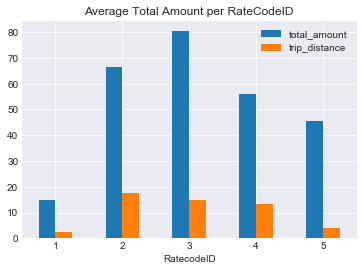

In [113]:
rc_tot = taxi.groupby("RatecodeID")
rc_tot[["total_amount", "trip_distance"]].mean().plot(kind="bar", title="Average Total Amount per RateCodeID")

plt.xticks(rotation=0)
plt.savefig("rc_total_amount-trip_distance.png")

There are some significant differences in the average total amount of the different  RatecodeID's! <br>
They are in a different scale. <br>
###### RatecodeID's 2-5: very few, very expensive rides. <br>
RatecodeID 1: Standard rate. Most of these rides might be typical NY "in-town" rides, so fare and distance are moderate.

In [337]:
taxi.total_amount.describe()

count   10815301.000
mean          15.965
std           12.054
min            0.300
25%            8.760
50%           12.300
75%           18.300
max          100.000
Name: total_amount, dtype: float64

In [314]:
taxi.groupby("payment_type").count().iloc[:,:1]/taxi.shape[0]*100 #percentages

,Unnamed: 0
payment_type,
1,65.875
2,33.650
3,0.356
4,0.120


In [484]:
taxi.groupby("payment_type").tip_amount.describe()

,count,mean,std,min,25%,50%,75%,max
payment_type,,,,,,,,
1,7124534.000,2.674,2.310,0.000,1.360,2.000,3.060,90.080
2,3639354.000,0.000,0.016,0.000,0.000,0.000,0.000,12.860
3,38463.000,0.000,0.030,0.000,0.000,0.000,0.000,3.760
4,12950.000,0.001,0.088,0.000,0.000,0.000,0.000,9.020


Most people pay with credit card. 

#### Only out of credit card payers we can make some inference about the tip amount. At least for them, it's 2.67$ on average.

In [162]:
pt1_feat = taxi[["tip_amount","total_amount", "trip_distance", "trip_duration", "average_speed"]]
pt1_corr = pt1_feat.corr()
pt1_corr.style.background_gradient()
##### Take screenshot of this!!! #####

,tip_amount,total_amount,trip_distance,trip_duration,average_speed
tip_amount,1,0.703126,0.556805,0.502946,0.294248
total_amount,0.703126,1,0.933516,0.852888,0.475678
trip_distance,0.556805,0.933516,1,0.770588,0.643196
trip_duration,0.502946,0.852888,0.770588,1,0.138005
average_speed,0.294248,0.475678,0.643196,0.138005,1


# Below are overall plot (for all RateCode's)

# Examining Trip distance, duration and speed

In [24]:
select = np.random.randint(0, taxi.shape[0], 100000)

Text(0.5,0,'Trip distance')

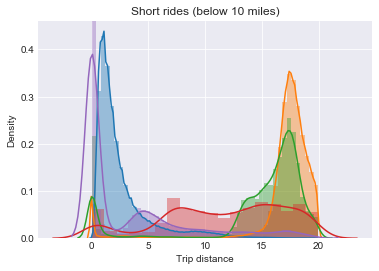

In [491]:
short_rides = taxi[["trip_distance", "RatecodeID"]][taxi.trip_distance < 20]
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==1], hist=True)
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==2], hist=True)
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==3], hist=True)
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==4], hist=True)
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==5], hist=True)
sns.set_style(style="darkgrid", rc=None)
plt.title("Short rides (below 10 miles)")
plt.ylabel("Density")
plt.xlabel("Trip distance")


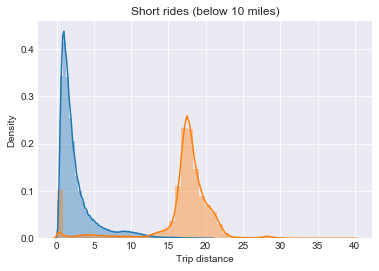

In [500]:
short_rides = taxi[["trip_distance", "RatecodeID"]][taxi.trip_distance < 40]
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==1], hist=True)
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]!=1], hist=True)

sns.set_style(style="darkgrid", rc=None)
plt.title("Short rides (below 10 miles)")
plt.ylabel("Density")
plt.xlabel("Trip distance")
#plt.savefig("rides.pdf")

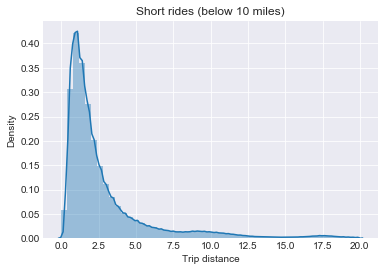

In [291]:
short_rides = taxi["trip_distance"][taxi.trip_distance < 20]
sns.distplot(short_rides, hist=True)
sns.set_style(style="darkgrid", rc=None)
plt.title("Short rides (below 10 miles)")
plt.ylabel("Density")
plt.xlabel("Trip distance")
plt.savefig("short_rides.pdf")

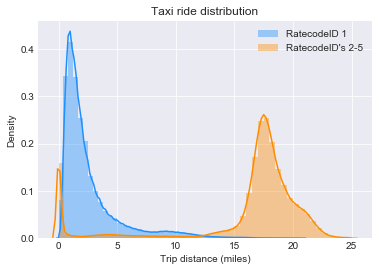

In [11]:
short_rides = taxi[["trip_distance", "RatecodeID"]][taxi.trip_distance < 25]
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==1], hist=True, label="RatecodeID 1", color="dodgerblue")
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]!=1], hist=True, label="RatecodeID's 2-5",color="darkorange")

sns.set_style(style="darkgrid", rc=None)

plt.legend()

plt.title("Taxi ride distribution")
plt.ylabel("Density")
plt.xlabel("Trip distance (miles)")
plt.savefig("rides.png")

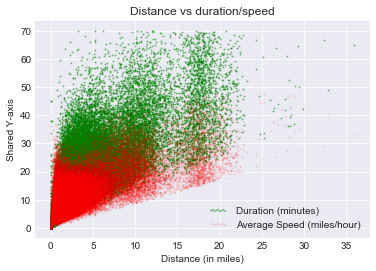

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(taxi.trip_distance[select], taxi.trip_duration[select], color="green", alpha=0.4, s=1, marker="o",
           label="Duration (minutes)")
ax.scatter(taxi.trip_distance[select], taxi.average_speed[select], color="red", alpha=0.1, s=1, marker="o",
           label="Average Speed (miles/hour)")
#ax.grid()
plt.xlabel("Distance (in miles)")
plt.ylabel("Shared Y-axis")
plt.title("Distance vs duration/speed")
plt.legend(loc = "best", scatterpoints=9)
#fig.tight_layout()
plt.savefig("distance_duration-speed.pdf")
plt.show()

This scatterplot demonstrates a positive correlation
between trip distance and duration. <br> An interesting finding is
that the variance of duration increases, as the trip distance
increases. <br>
Also we observe some odd values.

Positive correlation, heteroscedasticity. <br>
This can be attributed to the fact that longer distances usually
involve trip rides to/from areas outside the central city, thus
involving travel on less congested routes. therefore increasing
the average speed.

# Grouped by passenger count

Check importance of variable passenger count

In [340]:
taxi.groupby("passenger_count").count().iloc[:,:1]

,Unnamed: 0
passenger_count,
0,237
1,7670848
2,1558670
3,455286
4,217216
5,562427
6,350563
7,26
8,16


Explain why you kept these few observations with 7,8,9... and 0.

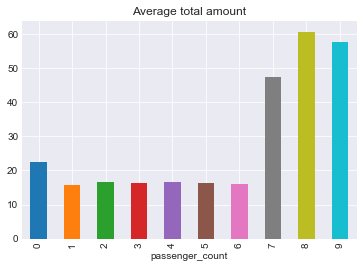

In [166]:
taxi.groupby("passenger_count").total_amount.mean().plot(kind="bar")
plt.title("Average total amount")
plt.savefig("total_amount_per_passenger_count.png")

Group rides are more expensive, keep them...

Rides with 7 passengers or more way more expensive on average. <br> 0 passengers doesn't make sense. There were very few observations we but kept them in the dataset because they also occur in the test set. 

# We didn't observe important differences between the payment type (excluding tip amount which is considerent only when paying with credit card)

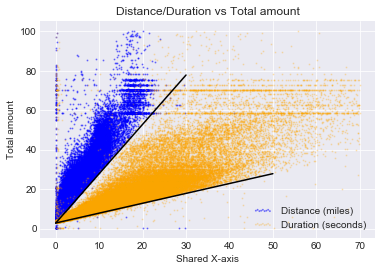

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(taxi.trip_distance[select], taxi.total_amount[select], color="blue", alpha=0.4, s=1, label="Distance (miles)")
ax.scatter(taxi.trip_duration[select], taxi.total_amount[select], color="orange", alpha=0.2, s=1, label="Duration (seconds)")
#ax.grid()
plt.ylabel("Total amount")
plt.xlabel("Shared X-axis")
plt.title("Distance/Duration vs Total amount")
ax.legend(loc = "best", scatterpoints=9)

#plt.plot([0,20], [10,60], color="black")  ###distance
#plt.plot([0,50], [5,30], color = "black")   ##duration   ### plot([x1,x2], [y1,y2])

### plot([x1,x2], [y1,y2])
plt.plot([0, 30], [2.8, 2.5*30+2.8], color="black")   ###distance   
plt.plot([0, 50], [2.8, 0.5*50+2.8], color="black")   ###duration

plt.savefig("petro2.pdf")
plt.show()

Positive correlation with both variables as expected. See next plots.

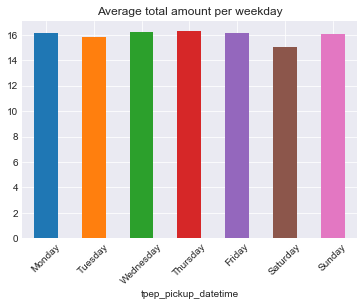

In [498]:
days = ["Monday Tuesday Wednesday Thursday Friday Saturday Sunday".split()]

taxi.groupby(taxi["tpep_pickup_datetime"].dt.dayofweek).mean().loc[:,"total_amount"].plot(kind="bar")
plt.title("Average total amount per weekday")  

plt.xticks([0,1,2,3,4,5,6], "Monday Tuesday Wednesday Thursday Friday Saturday Sunday".split(), rotation=45)
plt.savefig("average_total_amount_per_weekday.png")
plt.show()


No handles with labels found to put in legend.


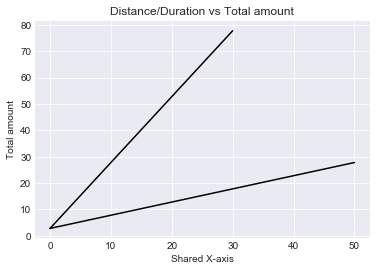

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
#ax.scatter(taxi.trip_distance[select], taxi.total_amount[select], color="blue", alpha=0.4, s=1, label="Distance (miles)")
#ax.scatter(taxi.trip_duration[select], taxi.total_amount[select], color="orange", alpha=0.2, s=1, label="Duration (seconds)")
#ax.grid()
plt.ylabel("Total amount")
plt.xlabel("Shared X-axis")
plt.title("Distance/Duration vs Total amount")
ax.legend(loc = "best", scatterpoints=9)

#plt.plot([0,20], [10,60], color="black")  ###distance
#plt.plot([0,50], [5,30], color = "black")   ##duration   ### plot([x1,x2], [y1,y2])

### plot([x1,x2], [y1,y2])
plt.plot([0, 30], [2.8, 2.5*30+2.8], color="black")   ###distance   
plt.plot([0, 50], [2.8, 0.5*50+2.8], color="black")   ###duration

plt.savefig("petro1.pdf")
plt.show()

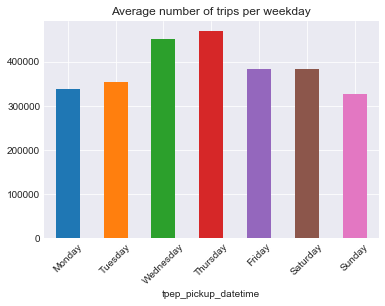

In [245]:
days = ["Monday Tuesday Wednesday Thursday Friday Saturday Sunday".split()]

(taxi.groupby(taxi["tpep_pickup_datetime"].dt.dayofweek).count().iloc[:,0] / 4).plot(kind="bar")
plt.title("Average number of trips per weekday")  # of trips. Over 4

plt.xticks([0,1,2,3,4,5,6], "Monday Tuesday Wednesday Thursday Friday Saturday Sunday".split(), rotation=45)
plt.savefig("number_of_trips_per_day.pdf")
plt.show()
# Average # of trips on each weekday in June

In [129]:
taxi.tpep_pickup_datetime.describe()

count                10815301
unique                2386055
top       2016-06-09 20:55:38
freq                       21
first     2016-06-01 00:00:00
last      2016-06-30 23:59:59
Name: tpep_pickup_datetime, dtype: object

C:\Users\Petro Ck\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if __name__ == '__main__':


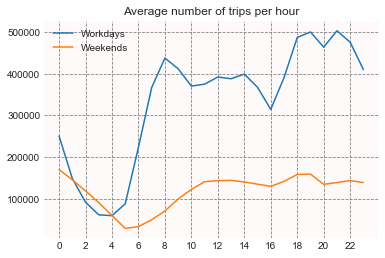

In [499]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(workdays.groupby(workdays.dt.hour).count(), label = "Workdays")
ax.plot(weekends.groupby(weekends.dt.hour).count(), label = "Weekends")
ax.legend(loc = "best")
plt.xticks(range(0,24, 2), rotation=0)
plt.grid(color='gray', linestyle='dashed')
plt.title("Average number of trips per hour")
ax.set_axis_bgcolor("snow")

plt.savefig("number_of_trips_per_hour.png")
plt.show()

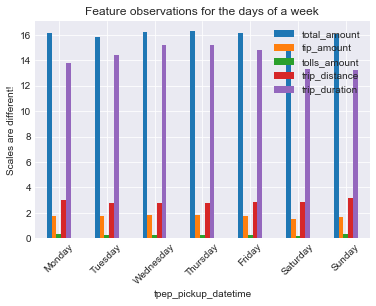

In [252]:
taxi[["total_amount",'tip_amount', 'tolls_amount', 
      'trip_distance','trip_duration']].groupby(pickup.dt.dayofweek).mean().plot(kind="bar")
plt.title("Feature observations for the days of a week")
plt.xticks([0,1,2,3,4,5,6], "Monday Tuesday Wednesday Thursday Friday Saturday Sunday".split(), rotation=45)
plt.ylabel("Scales are different!")
plt.savefig("feature_observations_dayofweek.pdf")

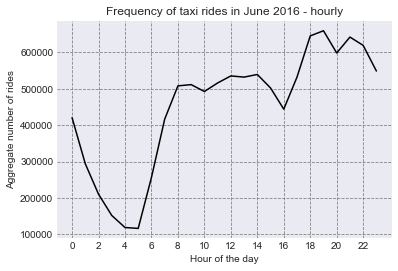

In [117]:
(taxi.groupby(pickup.dt.hour).count().iloc[:,0]).plot(color="black") #1 June is Sunday (0 start)
plt.xticks(range(0,24, 2), rotation=0)
plt.grid(color='gray', linestyle='dashed')
plt.ylabel("Aggregate number of rides")
plt.xlabel("Hour of the day")
plt.title("Frequency of taxi rides in June 2016 - hourly")
plt.grid(color='gray', linestyle='dashed')


plt.savefig("hourly_number_of_rides.png")

In [418]:
gc.collect()

106661

Average values!

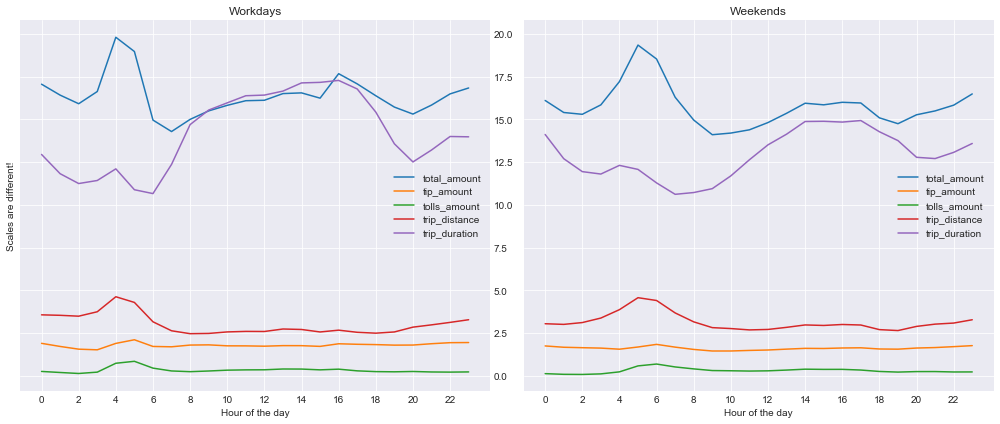

In [485]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(14,6))


ax1.plot(taxi[['total_amount','tip_amount', 'tolls_amount',
            'trip_distance','trip_duration']].groupby(workdays.dt.hour).mean())
ax1.set_title("Workdays")
ax1.set_xticks(range(0,24,2))
ax1.set_xlabel("Hour of the day")
ax1.set_ylabel("Scales are different!")
ax1.legend(['total_amount','tip_amount', 'tolls_amount',
            'trip_distance','trip_duration'], loc="best")
ax1.yaxis.tick_right()


ax2.plot(taxi[['total_amount','tip_amount', 'tolls_amount',
            'trip_distance','trip_duration']].groupby(weekends.dt.hour).mean())
ax2.set_title("Weekends")
ax2.set_xticks(range(0,24,2))
ax2.set_xlabel("Hour of the day")
#ax2.set_ylabel("Scales are different!")
ax2.legend(['total_amount','tip_amount', 'tolls_amount',
            'trip_distance','trip_duration'], loc="best")

plt.tight_layout()


plt.savefig("feature_observations_hourly.png")

### Workdays
We see that at night trip distance goes up, duration goes down. Highway longrides? <br>
TRip duration is elavated from 8-18 (work traffic?). A lot of traffic? We can observe clear patterns. <br>
Trips are more expensive in the night and in rush hours.

### Weekends
Trips again more distant and expensive from 20-7. Trip duration goes down in the morning and up again up during the day. <br>
Other than that, we have pretty constant measures.


In both graphs, longer distances during the morning hours. People drive to work?

In [ ]:
portions_train = taxi[["RatecodeID", "payment_type", "passenger_count", "VendorID", "store_and_fwd_flag"]].count().ilco[:,:1]
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]==1], hist=True, label="RatecodeID 1", color="dodgerblue")
sns.distplot(short_rides["trip_distance"][short_rides["RatecodeID"]!=1], hist=True, label="RatecodeID's 2-5",color="darkorange")

sns.set_style(style="darkgrid", rc=None)

plt.legend()

plt.title("Taxi ride distribution")
plt.ylabel("Density")
plt.xlabel("Trip distance (miles)")

In [37]:
taxi[["RatecodeID", "payment_type", "passenger_count", "VendorID", "store_and_fwd_flag"]].iloc[:,:1].count()

RatecodeID    10815301
dtype: int64

In [34]:
gc.collect()

24411

## Train set

In [57]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi.groupby("RatecodeID").count().iloc[:,:1]/taxi.shape[0]*100

,Unnamed: 0
RatecodeID,
1,98.16
2,1.50
3,0.13
4,0.04
5,0.17


In [58]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi.groupby("payment_type").count().iloc[:,:1]/taxi.shape[0]*100

,Unnamed: 0
payment_type,
1,65.87
2,33.65
3,0.36
4,0.12


In [91]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
taxi.groupby("passenger_count").count().iloc[:,:1]/taxi.shape[0]*100

,Unnamed: 0
passenger_count,
0,0.0022
1,70.9259
2,14.4117
3,4.2096
4,2.0084
5,5.2003
6,3.2414
7,0.0002
8,0.0001


In [89]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi.groupby("VendorID").count().iloc[:,:1]/taxi.shape[0]*100

,Unnamed: 0
VendorID,
1,46.86
2,53.14


In [88]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi.groupby("store_and_fwd_flag").count().iloc[:,:1]/taxi.shape[0]*100

,Unnamed: 0
store_and_fwd_flag,
N,99.42
Y,0.58


## Test set

In [83]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi_test.groupby("RatecodeID").count().iloc[:,:1]/taxi_test.shape[0]*100

,INDEX
RatecodeID,
1,78.12
2,10.94
3,6.25
4,1.56
5,3.12


In [84]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi_test.groupby("payment_type").count().iloc[:,:1]/taxi_test.shape[0]*100

,INDEX
payment_type,
1,67.11
2,32.24
3,0.48
4,0.16


In [85]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
taxi_test.groupby("passenger_count").count().iloc[:,:1]/taxi_test.shape[0]*100

,INDEX
passenger_count,
0,0.0063
1,69.7734
2,15.4203
3,4.3562
4,2.0266
5,5.1859
6,3.2266
8,0.0016
9,0.0031


In [86]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi_test.groupby("VendorID").count().iloc[:,:1]/taxi_test.shape[0]*100

,INDEX
VendorID,
1,46.30
2,53.70


In [87]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
taxi_test.groupby("store_and_fwd_flag").count().iloc[:,:1]/taxi_test.shape[0]*100

,INDEX
store_and_fwd_flag,
N,99.34
Y,0.66


# Not with barplots...

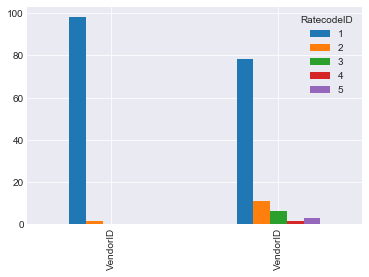

In [81]:
dist_rc = pd.DataFrame([taxi.groupby("RatecodeID").count().loc[:,"VendorID"]/taxi.shape[0]*100,
                       taxi_test.groupby("RatecodeID").count().loc[:,"VendorID"]/taxi_test.shape[0]*100])

dist_rc.plot(kind="bar")

In [79]:
taxi_test.shape[0]

64000

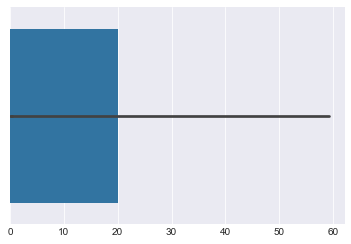

In [60]:
sns.barplot(taxi.groupby("RatecodeID").count().iloc[:,:1]/taxi.shape[0]*100)
sns.barplot(taxi_test.groupby("RatecodeID").count().iloc[:,:1]/taxi.shape[0]*100)

In [92]:
print(taxi_test.RatecodeID.unique())
print(taxi_test.payment_type.unique())
print(taxi_test.passenger_count.unique())
print(taxi_test.VendorID.unique())
print(taxi_test.store_and_fwd_flag.unique())

[1 2 3 4 5]
[1 2 4 3]
[1 2 5 4 6 3 9 0 8]
[1 2]
['N' 'Y']


In [93]:
print(taxi.RatecodeID.unique())
print(taxi.payment_type.unique())
print(taxi.passenger_count.unique())
print(taxi.VendorID.unique())
print(taxi.store_and_fwd_flag.unique())

[1 2 3 4 5]
[2 1 3 4]
[2 1 5 6 3 4 7 0 9 8]
[2 1]
['N' 'Y']


## After cleaning

In [98]:
taxi.groupby("RatecodeID").trip_distance.std()

RatecodeID
1   2.6705
2   3.9702
3   5.4605
4   6.4208
5   6.1604
Name: trip_distance, dtype: float64

In [99]:
taxi.shape[0]

10815275

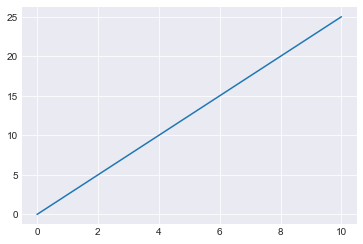

In [136]:
plt.plot([0,10], [0,25])

plt.show()

In [177]:
taxi.groupby("passenger_count").count()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,average_speed,night_trip,rush_hour
passenger_count,,,,,,,,,,,,,,,,,,,,,
0,237,237,237,237,237,237,237,237,237,237,...,237,237,237,237,237,237,237,237,237,237
1,7670848,7670848,7670848,7670848,7670848,7670848,7670848,7670848,7670848,7670848,...,7670848,7670848,7670848,7670848,7670848,7670848,7670848,7670848,7670848,7670848
2,1558670,1558670,1558670,1558670,1558670,1558670,1558670,1558670,1558670,1558670,...,1558670,1558670,1558670,1558670,1558670,1558670,1558670,1558670,1558670,1558670
3,455286,455286,455286,455286,455286,455286,455286,455286,455286,455286,...,455286,455286,455286,455286,455286,455286,455286,455286,455286,455286
4,217216,217216,217216,217216,217216,217216,217216,217216,217216,217216,...,217216,217216,217216,217216,217216,217216,217216,217216,217216,217216
5,562427,562427,562427,562427,562427,562427,562427,562427,562427,562427,...,562427,562427,562427,562427,562427,562427,562427,562427,562427,562427
6,350563,350563,350563,350563,350563,350563,350563,350563,350563,350563,...,350563,350563,350563,350563,350563,350563,350563,350563,350563,350563
7,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
8,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [204]:
taxi[(taxi.passenger_count == 0) & (taxi.RatecodeID !=5)].count().iloc[3:4]

VendorID    3
dtype: int64

In [164]:
taxi_test.passenger_count()

array([1, 2, 5, 4, 6, 3, 9, 0, 8], dtype=int64)

In [170]:
taxi.groupby("RatecodeID").count()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,average_speed,night_trip,rush_hour
RatecodeID,,,,,,,,,,,,,,,,,,,,,
1,10616518,10616518,10616518,10616518,10616518,10616518,10616518,10616518,10616518,10616518,...,10616518,10616518,10616518,10616518,10616518,10616518,10616518,10616518,10616518,10616518
2,162423,162423,162423,162423,162423,162423,162423,162423,162423,162423,...,162423,162423,162423,162423,162423,162423,162423,162423,162423,162423
3,14145,14145,14145,14145,14145,14145,14145,14145,14145,14145,...,14145,14145,14145,14145,14145,14145,14145,14145,14145,14145
4,3909,3909,3909,3909,3909,3909,3909,3909,3909,3909,...,3909,3909,3909,3909,3909,3909,3909,3909,3909,3909
5,18306,18306,18306,18306,18306,18306,18306,18306,18306,18306,...,18306,18306,18306,18306,18306,18306,18306,18306,18306,18306
